# Test on a scATAC dataset with rare-cell group

In [1]:
#%% library
import time 
from numpy import *
from scipy.sparse import *    
import anndata as ad
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans,DBSCAN
import scBiMapping
import warnings
warnings.filterwarnings("ignore")
from fast_ldp_mst_clustering import FastLDPMST

## Load dataset

In [ ]:
adata = ad.read_h5ad('CD8_0.01.h5ad')
print(adata)
nc = len(unique(adata.obs['cell_annotation']))
print('number of cell types: ' + str(nc))

AnnData object with n_obs × n_vars = 1010 × 135687
    obs: 'cell_annotation', 'batch'
number of cell types: 6


## embedding

In [ ]:
%%time
n_embedding = 30
print('the embedding dimension: ' + str(n_embedding))
scBiMapping.scBiMapping_DR(adata,n_embedding = n_embedding)
print(adata)

the embedding dimension: 30
AnnData object with n_obs × n_vars = 1010 × 135687
    obs: 'cell_annotation', 'batch'
    uns: 'V'
    obsm: 'U'
CPU times: user 6.77 s, sys: 691 ms, total: 7.46 s
Wall time: 2.9 s


## clustering

In [4]:
clustering_method_list = ['Kmeans','leiden','FastLDPMST']

### method 1: kmeans

In [5]:
adata.obs['Kmeans'] = pd.Categorical(KMeans(nc,init = 'k-means++',n_init = 1).fit(adata.obsm['U']).labels_.astype('str'))

### method 2: leiden

In [6]:
sc.pp.neighbors(adata,use_rep = 'U',n_neighbors = 30) 
sc.tl.leiden(adata,resolution = 0.7)

### method 3: FastLDPMST

In [7]:
N,Dim = adata.shape
K = int(ceil(log2(N)))- 5
ratio = 0.01; # [0.01,0.02] is recommended; not needed for manual cutting; 
MinSize = ratio*N       
if Dim <= 10:
    knnMethod = 'KD-tree';
else:
    knnMethod = 'NNDescent'; # HNSW or NNDescent
labels,_,_ = FastLDPMST(adata.obsm['U'], nc, MinSize, K, knnMethod) 
adata.obs['FastLDPMST'] = pd.Categorical(labels.astype('str'))

find knn...
Search natural neighbors...
supk = 3
  Cut (stage 1): determine node weight in the constructed forest...
  cost time on 1st stage of Cut: 0.0005023479461669922s
  Cut (stage 2): check the edges one by one in decreasing order of edge weight...
  time cost on the 2nd stage of Cut: 2.956390380859375e-05s


## umap-based visualization

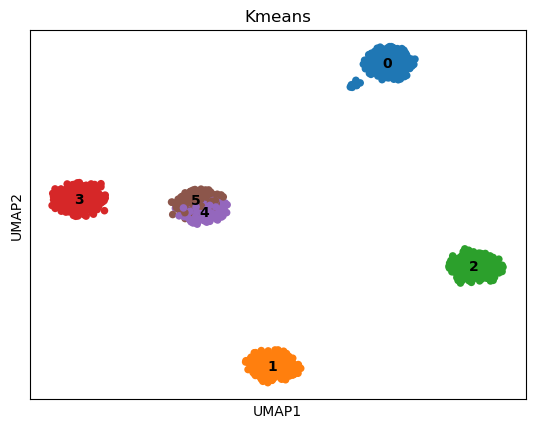

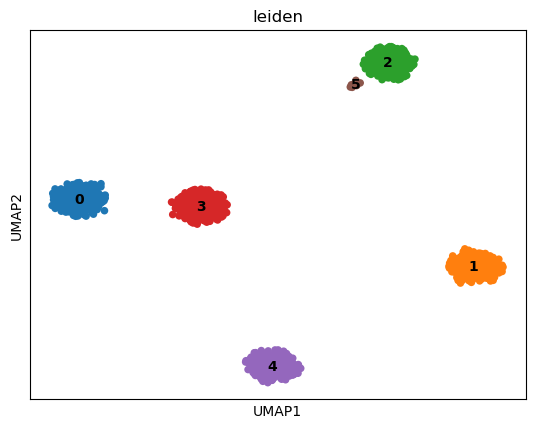

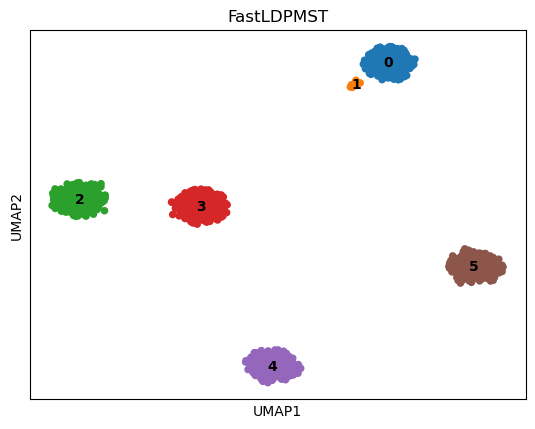

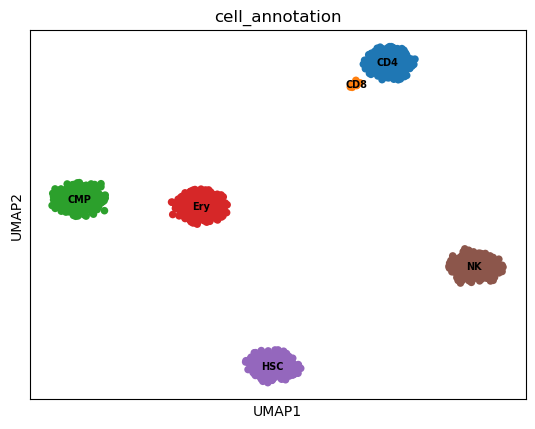

In [8]:
sc.tl.umap(adata, random_state=1)
for clustering_method in clustering_method_list:
    sc.pl.umap(adata, color=clustering_method,legend_loc='on data',legend_fontsize = 10)
sc.pl.umap(adata, color='cell_annotation',legend_loc='on data',legend_fontsize = 7)